# Advanced Statistics for Quantitative Trading
<div class="alert alert-info"><strong>Part II : Time Series Modeling with Python</strong></div>

#### Notebook Created on: 6 July 2020
##### Last Update: 14 Apr 2023
##### Version 5
##### Author: Vivek Krishnamoorthy

## **Agenda for today**

- Checking for stationarity
- Modeling time series using ARIMA models
- Training the `ARIMA(2, 1, 2)` model
- Create a trading strategy using the `ARIMA(2, 1, 2)` model
- Finding the best `ARIMA` model
- Extras: Anatomy of a time series process
- Extras: Modeling a time series process using `seasonal_decomposition`
- Extras: Rabbit hole - Exploring oil price seasonality
- Introduction to volatility
- Introduction to ARCH/GARCH models for modeling volatility
- Comparing forecasts of ARCH/GARCH

### Checking for stationarity

There are three ways of checking for stationarity in a time series.
1. Visual inspection
2. Statistical tests
3. ACF/PACF plots

We prefer working with stationary time series processes because it makes modeling, analysis and forecasting more feasible.

For this section, we work with the last 25 years of daily gold prices in India. The prices shown are denominated in INR per ounce.

> *Gold is a liquid asset, ranking at levels comparable to many global stock markets as well as currency spreads. Its liquidity is often sourced during periods of stress in the markets, one of its appealing qualities.* - [Source](https://www.gold.org/goldhub/data/trading-volumes)


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import nasdaqdatalink

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

plt.style.use('seaborn-darkgrid')

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as sms
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA

In [3]:
from tsa_functions import model_performance, analyze_strategy, check_stationarity

In [4]:
start6 = '1995-01-01'
end6 = '2022-09-29'
ticker6 = "WGC/GOLD_DAILY_INR"

In [5]:
df = nasdaqdatalink.get(dataset=ticker6, start_date=start6, end_date=end6)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker6} data")

Downloaded 6575 rows and 1 columns of WGC/GOLD_DAILY_INR data


In [6]:
df.head()

,Value
Date,
1995-01-02,12022.09
1995-01-03,11948.83
1995-01-04,11781.62
1995-01-05,11771.27
1995-01-06,11769.08


In [7]:
df.tail()

,Value
Date,
2020-03-09,123911.33
2020-03-10,122666.66
2020-03-11,121778.01
2020-03-12,116573.42
2020-03-13,115510.47


In [8]:
df6 = df.copy()

In [9]:
df6.rename(columns={"Value": "price"}, inplace=True)

In [ ]:
check_stationarity?

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic          1.054921
p-value                 0.994813
# of Lags                   32.0
# of Observations         6542.0
Critical Value (1%)       -3.431
Critical Value (5%)       -2.862
Critical Value (10%)      -2.567
dtype: object
--------------------------------------------------------------


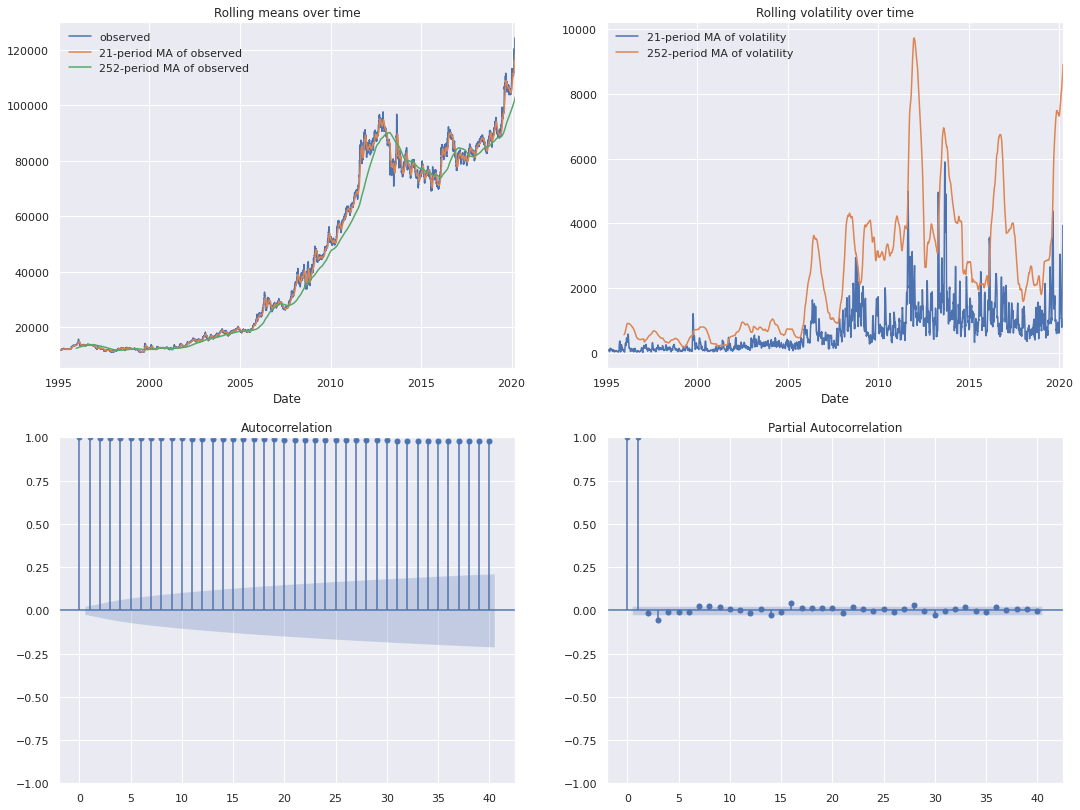

In [10]:
check_stationarity(df6['price'])

Observations:
- In the ADF test, if the test statistic is greater than the critical value, we conclude that the series is non-stationary. We can draw the same conclusion by examining the p-value. A p-value greater than our significance level (conventionally 5%) means we cannot reject our null hypothesis (The series is not stationary). 
- For the gold prices, we have a p-value of nearly 1 (and equivalently the test statistic is greater than the critical values at all 3 significance levels), so we conclude that the price series is not stationary.
- The rolling means and volatility plots are time-varying. So we also conclude visually that gold prices in India are non-stationary.
- From the ACF, there are significant autocorrelations above the 95% confidence interval at all lags. From the PACF, we have significance in autocorrelations at lags 1, 2, 3, 6, and 8.

In [11]:
df6['log_returns'] = np.log(df6['price'] / df6['price'].shift(1))
df6.dropna(axis='rows', how='any', inplace=True)

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -17.500127
p-value                       0.0
# of Lags                    26.0
# of Observations          6547.0
Critical Value (1%)        -3.431
Critical Value (5%)        -2.862
Critical Value (10%)       -2.567
dtype: object
--------------------------------------------------------------


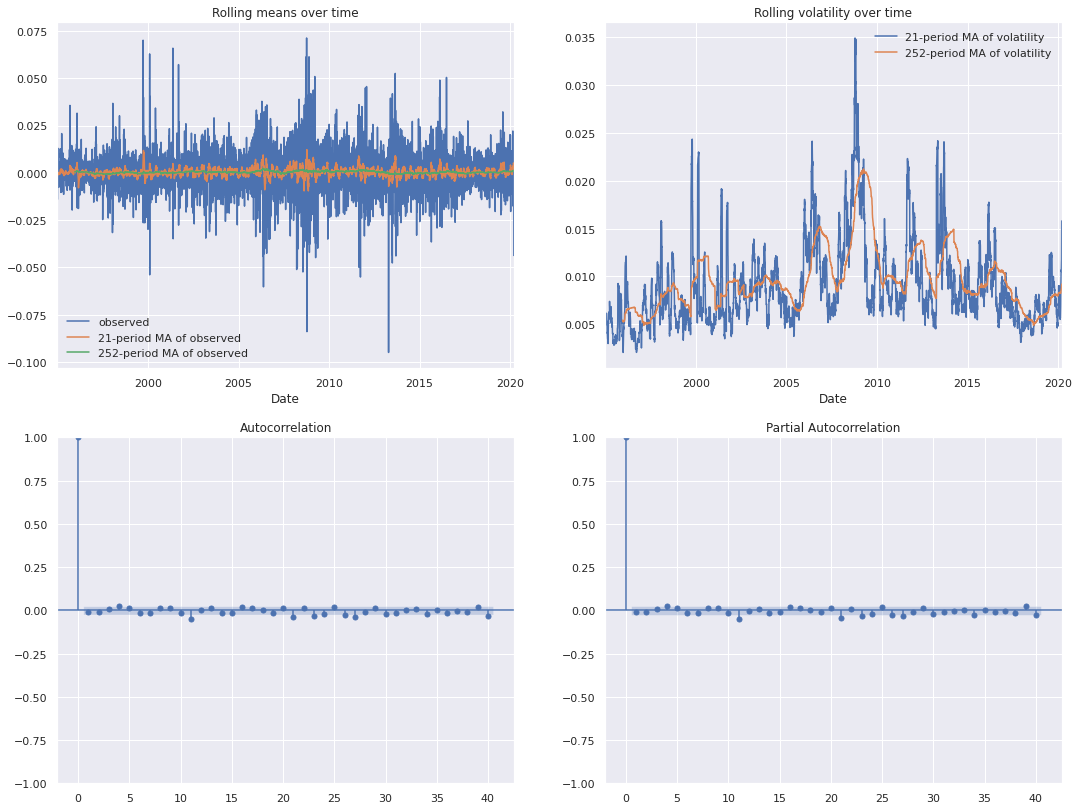

In [12]:
check_stationarity(df6['log_returns'])

Points to note:
- As per the ADF test results, the returns of gold are stationary since the p-value is almost 0 and the test statistic is less than all the critical values.
- The returns and rolling means of the returns are all centred around 0. As the time scale increases, the means become more and more constant. At shorter time scales, the noise tends to obscure the signal.
- The volatily is time-varying at both the faster and slower rolling levels.
- There are little spikes in the ACF plot at lags 3, 11, and 21.

### Modeling time series using ARIMA models

The **ARIMA (AutoRegressive Integrated Moving Average)** class of models is a popular statistical technique in time series forecasting. It exploits different standard temporal structures seen in time series processes.

> *Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.* - [Source](#hyndman)

##### ***Crash course on ARIMA***
We will now take a brief look at its key features by taking apart the acronym.

1. **Auto Regressive (AR)**:

- Regression of a time series process onto itself (its past versions)
- A time series process is $AR$ if its present value depends on a linear combination of past observations.
- In financial time series, an $AR$ model attempts to explain the mean reversion and trending behaviours that we observe in asset prices.

2. **Integrated (I)**:

For a time series process ${X_t}$ recorded at regular intervals, the difference operation is defined as $$\nabla X_t = X_t - X_{t-1}$$

The difference operator (denoted by $\nabla$) can be applied repeatedly. For example, 
$$\nabla^2 X_t = \nabla X_t - \nabla X_{t-1}$$

- A time series process is integrated of order $d$ (denoted by $I(d)$), if differencing the observations $d$ times, makes the process stationary.

3. **Moving Average (MA)**:

-  A time series process is $MA$ if its present value can be written as a linear combination of past error terms.
- $MA$ models try to capture the idiosyncratic shocks observed in financial markets. We can think of events like terrorist attacks, earnings surprises, sudden political changes, etc. as the random shocks affecting the asset price movements.

When we use the ARIMA class to model a time series process, each of the above components are specified in the model as parameters (with the notations $p$, $d$, and $q$ respectively). 

That is, the classification $ARIMA(p, d, q)$ process can be thought of as $$AR(p)I(d)MA(q)$$ 
Here,

1. $p$: The number of past observations (we usually call them *lagged terms*) of the process included in the model.
2. $d$: The number of times we difference the original process to make it stationary.
3. $q$: The number of past error terms (we usually call them *lagged error terms* or *lagged residuals*) of the process included in the model.

When we model our time series process with the ARIMA class, we implicitly assume that the underlying data generating process (and by extension the observations we record) is an ARIMA process. 

We should validate our assumptions (especially the implicit ones which slip under the radar) and recognize the limitations of our models. A well-known deficiency of ARIMA applications on financial time series is its failure to capture the phenomenon of volatility clustering. However, despite their inaccurate point estimates, they give rise to informative confidence intervals.

 **All of the below models would have good explanatory and predictive power only if the process is stationary.**

$$AR(1) : X_t = \phi X_{t-1} + \epsilon_t$$
$$MA(1) : X_t = \epsilon_t + \theta \epsilon_{t-1}$$

$$AR(p) : X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t$$
$$MA(q) : X_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_q$$

$$ARMA(p, q) : X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \dots + \phi_p X_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_q$$

I use sections of the Quantra course on Time Series Analysis of Financial Markets for code and data in some of the following parts.

We now fit an ARIMA model working with the the AUDUSD data. The data is from January to July 2020 at 4-hourly intervals.

In [13]:
# Read the csv file

data = pd.read_csv("AUDUSD_2020.csv", index_col=0)
data.index = pd.to_datetime(data.index)

# Drop the missing values
data = data.dropna()

# Rolling Window
rolling_window = int(len(data)*0.70)

In [14]:
data.tail()

,open,high,low,close,volume
2020-07-24 12:00:00+00:00,0.708,0.708,0.706,0.708,57810000.0
2020-07-24 16:00:00+00:00,0.708,0.710,0.707,0.709,69354000.0
2020-07-24 20:00:00+00:00,0.709,0.710,0.708,0.709,35084000.0
2020-07-25 00:00:00+00:00,0.709,0.710,0.709,0.710,3602000.0
2020-07-27 00:00:00+00:00,0.709,0.709,0.709,0.709,324000.0


In [15]:
data.head()

,open,high,low,close,volume
2020-01-01 00:00:00+00:00,0.701,0.701,0.701,0.701,2629000.0
2020-01-02 00:00:00+00:00,0.701,0.699,0.701,0.699,24000.0
2020-01-02 04:00:00+00:00,0.701,0.699,0.701,0.699,5760000.0
2020-01-02 08:00:00+00:00,0.701,0.700,0.699,0.700,8218000.0
2020-01-02 12:00:00+00:00,0.700,0.700,0.699,0.699,14922000.0


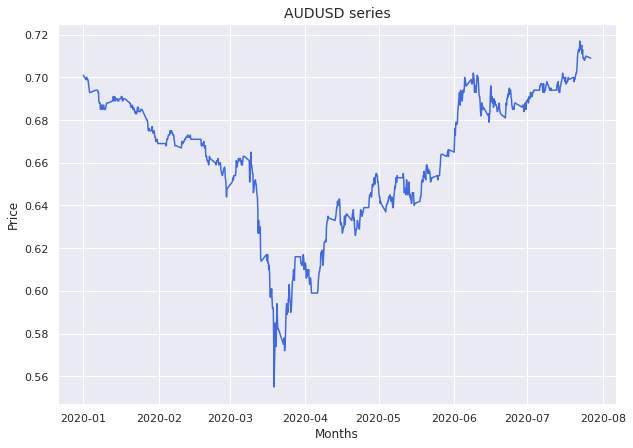

In [16]:
# Plot the series
plt.figure(figsize=(10, 7))
plt.plot(data['close'], 'royalblue')
plt.title("AUDUSD series", fontsize=14)
plt.grid(True)
plt.xlabel("Months", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.show()

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -1.338434
p-value                  0.61141
# of Lags                   15.0
# of Observations          870.0
Critical Value (1%)       -3.438
Critical Value (5%)       -2.865
Critical Value (10%)      -2.569
dtype: object
--------------------------------------------------------------


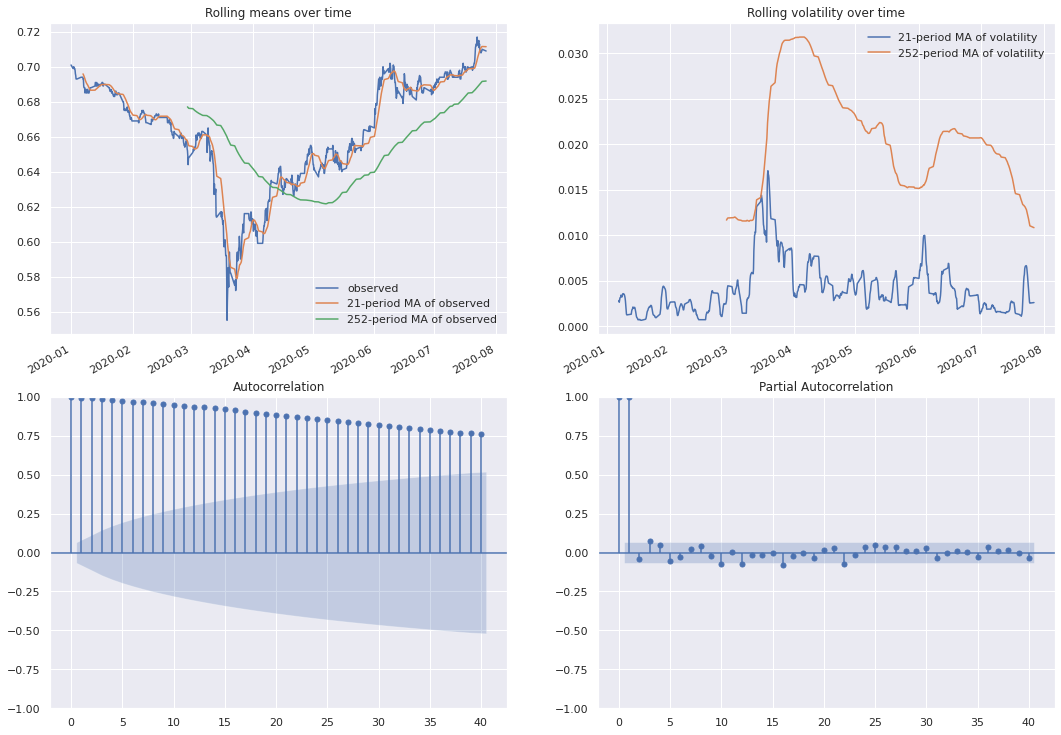

In [17]:
check_stationarity(data['close'])

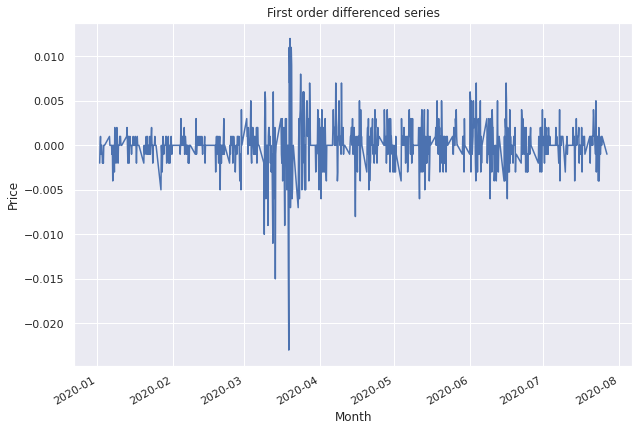

In [18]:
# Stationarizing the data by applying first differences

# Difference of the series
stationary_series = data['close'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 7))
stationary_series.plot()
plt.title('First order differenced series')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)
plt.show()

--------------------------------------------------------------
--------- The augmented Dickey-Fuller test results -----------
--------------------------------------------------------------
Test Statistic         -6.058541
p-value                      0.0
# of Lags                   14.0
# of Observations          870.0
Critical Value (1%)       -3.438
Critical Value (5%)       -2.865
Critical Value (10%)      -2.569
dtype: object
--------------------------------------------------------------


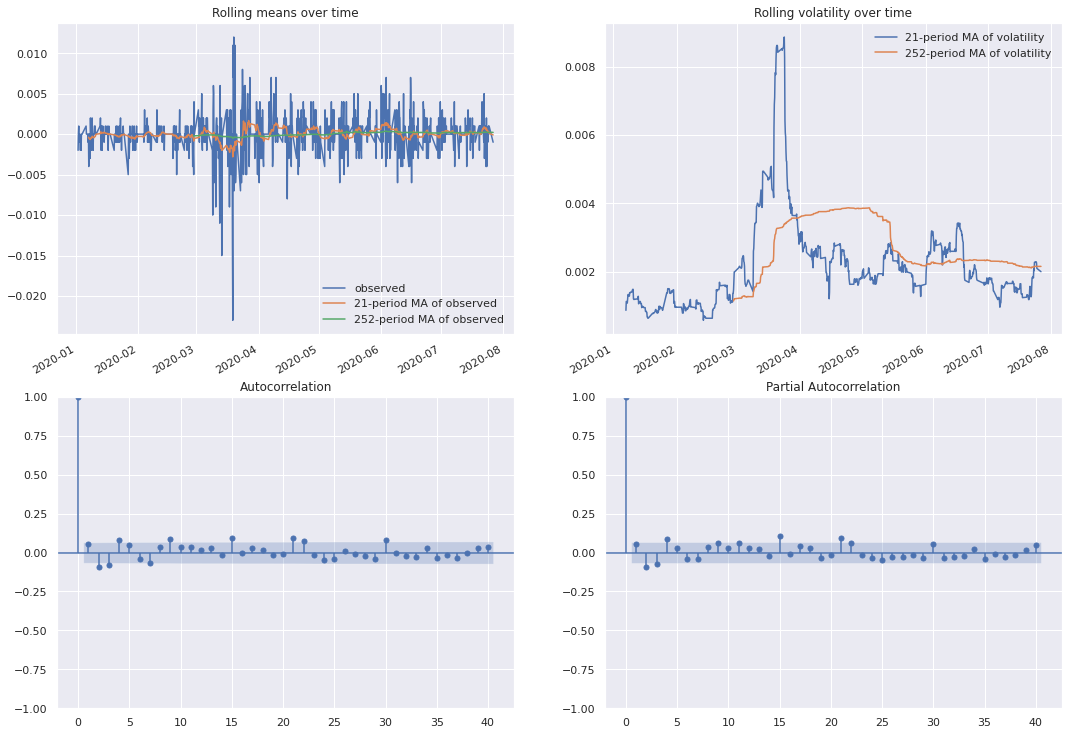

In [19]:
check_stationarity(stationary_series)

The series is stationary as seen above. We can therefore infer that the order of difference is `d=1`.

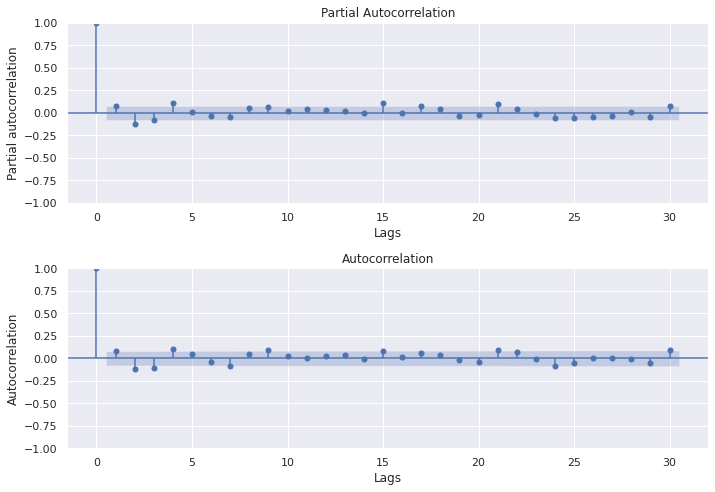

In [20]:
# Trying to find the order of AR and MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Plot PACF
sm.graphics.tsa.plot_pacf(data['close'][:rolling_window].diff().dropna(), lags=30, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial autocorrelation')

# Plot ACF
sm.graphics.tsa.plot_acf(data['close'][:rolling_window].diff().dropna(), lags=30, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

From the PACF plot above, we see statistically significant spikes at lag 1, 2, 3, and 4. From the ACF plot above, we see similar spikes at lag 1, 2, 3, 4. A reasonable starting point for the order of the AR and MA parts can be 2 and 2. We avoid choosing higher orders to avoid the risk of overfitting.

## Training the `ARIMA(2, 1, 2)` model

In [21]:
%%time

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima.model.ARMA',
                        FutureWarning)

# Fit ARIMA model
model = ARIMA(data['close'][:rolling_window], order=(2, 1, 2))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2))

ar.L1     0.02
ar.L2    -0.73
ma.L1     0.07
ma.L2     0.63
sigma2    0.00
dtype: float64
CPU times: user 924 ms, sys: 43.3 ms, total: 967 ms
Wall time: 1.07 s


From the above, we see that the model is $ARIMA(2, 1, 2)$ for $Y_t$. If we first difference $Y_t$ to get $Z_t = Y_t - Y_{t-1}$, then the above model is equivalent to an $ARMA(2, 2)$ for $Z_t$. The above model can be restated as shown below.

$$Z_t = Y_t - Y_{t-1}$$
$$ARMA(2, 2) : Z_t = 0.02 Z_{t-1} - 0.73Z_{t-2} + 0.07\epsilon_{t-1} + 0.63\epsilon_{t-2} + \epsilon_t$$

In [22]:
print(model_fit_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  620
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2789.021
Date:                Fri, 14 Apr 2023   AIC                          -5568.043
Time:                        15:35:31   BIC                          -5545.902
Sample:                             0   HQIC                         -5559.436
                                - 620                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0172      0.091      0.189      0.850      -0.162       0.196
ar.L2         -0.7283      0.073    -10.000      0.000      -0.871      -0.586
ma.L1          0.0721      0.095      0.757      0.4

In [23]:
# Function to predict the price of 1 day
def predict_price_ARIMA(train_data):
    # Define model
    model = ARIMA(train_data, order=(2, 1, 2))
    # Fit the model
    model_fit = model.fit(start_params=model_fit_0.params)
    # Make forecast
    return model_fit.forecast().iloc[0]

In [24]:
%%time

# Predict the price using `predict_price_ARIMA` function
data['predicted_price'] = data['close'].rolling(
    rolling_window).apply(predict_price_ARIMA)
# Shift the predicted price by 1 period
data['predicted_price'] = data['predicted_price'].shift(1)

CPU times: user 2min 32s, sys: 3.22 s, total: 2min 36s
Wall time: 42.6 s


The Mean Absolute Error is 0.00
The Mean Squared Error is 0.00
The Root Mean Squared Error is 0.00
The Mean Absolute Percentage Error is 0.23


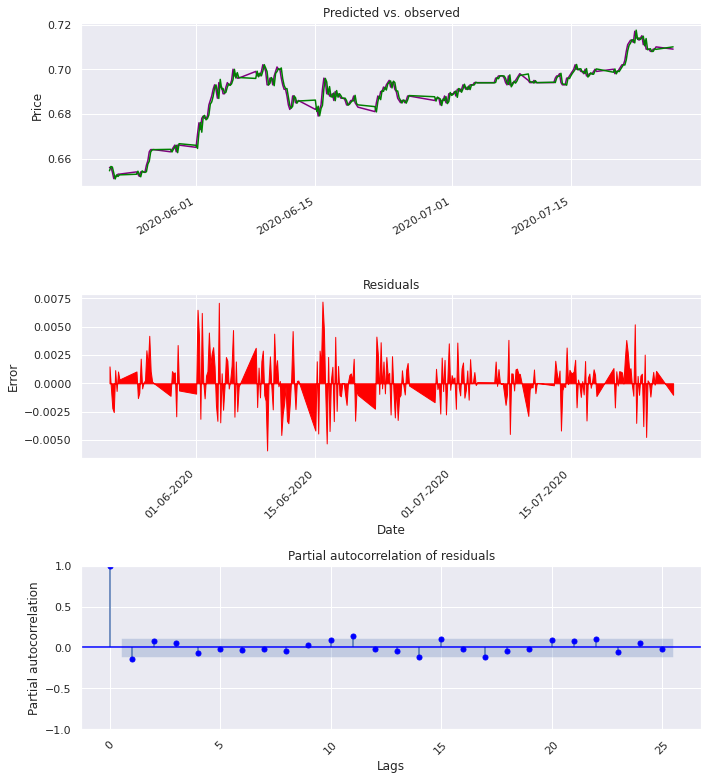

In [25]:
# Call `model_performance` to evaluate the performance of the model
model_performance(data['close'].iloc[rolling_window:],
                  data['predicted_price'].iloc[rolling_window:])

From the first and second plot above, we see that the residuals are randomly distributed and small in magnitude.

From the third plot, we see that there is a statistically significant spike at lag 1.This indicates the presence of autocorrelation in the residuals.

## Create a trading strategy using the `ARIMA(2, 1, 2)` model

In [26]:
# Create signal
data['signal'] = np.where(data.predicted_price.shift(1) <
                          data.predicted_price, 1, 0)

data['returns'] = data['close'].pct_change()

data['strategy_returns'] = data.signal.shift(
    1) * data.iloc[rolling_window:].returns

## Analyze the performance of the strategy

The Sharpe Ratio is 1.38
The cumulative return is 5.06%
The maximum drawdown is -2.72%


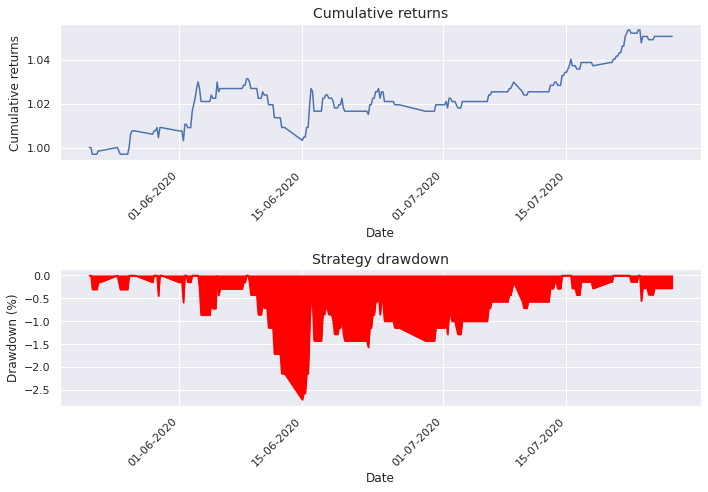

In [27]:
# Call `analyze_strategy`
analyze_strategy(data['strategy_returns'].iloc[rolling_window:])

Observations:
- We chose an $ARIMA(2, 1, 2)$ model to fit the price series of `AUDUSD`. Equivalently, we could have fit an $ARIMA(2, 0, 2)$ to the returns instead. 
- The `summary()` method provides the results of the model fitting exercise on the **in-sample data set** (a.k.a. the training data).
- The table at the centre has the coefficient values, their 95% confidence intervals and their corresponding p-values.
- However, we also need to examine the residual errors closely. This will tell us if our model was a good fit to the underlying data.

## Finding the best ARIMA model

In [28]:
# Read the csv file

data = pd.read_csv("AUDUSD_2020.csv", index_col=0)
data.index = pd.to_datetime(data.index)

# Drop the missing values
data = data.dropna()

# Rolling Window
rolling_window = int(len(data)*0.70)

In [29]:
# Setting the rolling window
rolling_window = int(len(data) * 0.70)

# Function to select the best model and forecast the price
def select_model_and_forecast(price_df):
    
    # The p,d and q values
    aic = []
    p = range(1, 3)
    d = range(0, 2)
    q = range(1, 3)

    # Empty list to store p, d, q
    p_d_q = []

    # Get the aic score for different values of p, d and q
    for i in p:
        for j in d:
            for k in q:
                # Try to fit the model
                try:
                    gm = ARIMA(price_df, order=(i, j, k))
                    gm_fit = gm.fit()
                    
                    # Calculate the AIC score
                    aic_temp = gm_fit.aic
                    order_temp = (i, j, k)
                    
                    # Save the AIC score and the p, d and q values
                    p_d_q.append(order_temp)
                    aic.append(aic_temp)
                except:
                    # Do nothing when the model does not fit
                    pass

    # Store values in dictionary
    aic_dict = {'p_d_q': p_d_q, 'aic': aic}

    # Create DataFrame from dictionary
    df = pd.DataFrame(aic_dict)

    # Get the minimum AIC value with the p,d and q values
    df = df[df['aic'] == df['aic'].min()].reset_index()

    # Only predict the price if the ARIMA model could be fit
    if len(df) > 0:
        # Fitting the optimum model
        gm = ARIMA(price_df, order=df.p_d_q[0])
        gm_fit = gm.fit()
        
        # making the forecast
        predicted_price = gm_fit.forecast().iloc[0]
        return predicted_price
    else:
        # Return -1 if the model could not be fit
        return -1

___Note: The below cell will take a while to run (at least 10 minutes). Please be patient.___

In [ ]:
%%time

# Applying the `select_model_and_forecast` function to the price data
data['predicted'] = data['close'].rolling(rolling_window).apply(select_model_and_forecast)

## Generate signals for the strategy

We go long on the asset the predicted price is greater than the close, and go short when for the reverse condition.

In [ ]:
# Generate the signal
data['signal'] = np.where(data['predicted'] > data['close'], 1, -1)

# Calculate strategy returns
data['strategy_returns'] = data['close'].pct_change() * data['signal'].shift(1) 
# Drop the rows where there is NaN value
data.dropna(inplace=True)

In [ ]:
analyze_strategy(data['strategy_returns'])

Observations:

- Our guiding principle when we build models is [Occam's Razor](http://pespmc1.vub.ac.be/OCCAMRAZ.html) i.e. we want a model with the fewest parameters that can explain our time series process. 
- We therefore use information criterion ([Akaike Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion)).
- When choosing from multiple competing models, we choose the one which has the smallest AIC.
- The idea is to find the right balance between underfitting and overfitting. AIC helps us find that.

## Tweak the code
You can tweak the code in the following ways:

1. Use different assets and see how the strategy performs
1. Use a larger range of p and q values for the ARIMA model selection. Please note that larger order models may result in overfitting.

<a id = 'convert'></a>

### Extras: Anatomy of a time series process

Time series processes have a wide variety of patterns. So it is helpful to consider them as a combination of *systematic* and *unsystematic* components.

- **Systematic**: These are recurring in nature and so can be described and modeled.
- **Non-systematic**: These are random in nature and so cannot be directly modeled.

The systematic components can be further split into *level*, *trend*, and *seasonality* whereas the non-systematic component is referred to as *noise*.

- **Level**: The average value of the process.
- **Trend**: The direction and rate of change of the process. The slope is a good proxy for it.
- **Seasonality**: Deviations in the process caused by recurring short-term cycles.
- **Noise**: The random variation observed in the process.

Another useful abstraction while analyzing time series processes is to see them as either an *additive* or a *multiplicative* blend of the four constituent parts mentioned.

**Additive model**: The process $X(t)$ has the form
$$X(t) = Level + Trend + Seasonality + Noise$$

We use an additive model when the underlying process under examination has the following characteristics.
- The process changes remain constant over time (i.e. they are linear). So the trend line would be straight.
- It shows linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles remain constant over time.



**Multiplicative model**: The process $X(t)$ has the form
$$X(t) = Level \times Trend \times Seasonality \times Noise$$

We use a multiplicative model when the underlying process under examination has the following characteristics.
- The process changes vary over time (i.e. they are non-linear in nature).
- An exponential or quadratic or higher order polynomial process is multiplicative. So the trend-line would be curved, not straight. 
- It shows non-linear seasonality. That is to say the frequency and amplitude (i.e. the width and the height) of the cycles vary over time.

In the (harsh) real world, we often encounter non-linear or even mixed processes and therefore have to work with the multiplicative model as our prototype. But we prefer to work with linear processes as they are easier to use. So we transform the original process into a linear one. A commonly used trick is applying a log transformation.

### Extras: Modelling a time series using decomposition

There are several available libraries (ex. [`statsmodels`](https://www.statsmodels.org/stable/tsa.html), [`prophet`](https://facebook.github.io/prophet/docs/quick_start.html), [`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), [`PyFlux`](https://pyflux.readthedocs.io/en/latest/), [`fecon236`](https://github.com/MathSci/fecon236), [`PM-Prophet`](https://github.com/luke14free/pm-prophet) at the time of this writing) in Python to develop sophisticated time series models for forecasting. 

We work with `statsmodels`. Both offer convenient routines to automatically decompose a time series into their fundamental components.

To illustrate the ideas, we make use of the daily historical prices of crude oil (from 2003 to 2022).

> *The OPEC Reference Basket (ORB), also referred to as the OPEC (Organization of Petroleum Exporting Countries ex. Qatar, Saudi Arabia, Iran, Iraq) Basket, is a weighted average of prices for petroleum blends produced by OPEC members. It is used as an important benchmark for crude oil prices. The OPEC Basket, including a mix of light and heavy crude oil products, is heavier than both Brent crude oil, and West Texas Intermediate crude oil.* - [Source](https://www.investopedia.com/terms/o/opecbasket.asp)



We try the `seasonal_decompose` method from the `statsmodels.tsa` sub-library.

### Extras: Seasonal decomposition using the `seasonal_decompose` routine in `statsmodels` 

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import nasdaqdatalink

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [ ]:
end4 = datetime.date(2022, 12, 31)
start4 = datetime.date(2003, 1, 1)

ticker4 = "OPEC/ORB"

In [ ]:
## ***********************************************************
## ***** EXPERIMENTAL : IGNORE THIS CELL *********************
## Trials with other commodity data
## ***********************************************************

# "OPEC/ORB" this is crude oil prices per barrel
# WGC/GOLD_DAILY_INR for daily gold prices in India available until 10 March 2020
# TFGRAIN/SOYBEANS for daily soy bean prices per bushel
# WORLDAL/PALPROD primary aluminium production across continents. not tried.

In [ ]:
df = nasdaqdatalink.get(dataset=ticker4, start_date=start4, end_date=end4)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker4} data")

In [ ]:
df4 = df.copy()

In [ ]:
print(df4.head(10))
print(df4.tail())

In [ ]:
df4.rename(columns={'Value': 'price'}, inplace=True)

In [ ]:
oil_long_run_mean = np.round(df4['price'].mean(), 1)
print(oil_long_run_mean)

In [ ]:
df4.plot(figsize=(12, 9), linewidth=0.8, color='indigo')
plt.title(f"{ticker4} prices over time", fontsize=20)
for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

plt.axhline(df4['price'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
plt.legend()

Points to note:
- There are upward and downward trends in the prices. Looks linear. Needs further probing.
- There seems to be seasonality and we can investigate further by looking at some moving averages.

In [ ]:
window_length = 21 # for 1 monthly moving average calculations
window_length2 = 252 # for annual moving average calculations

## Calculating 21-day rolling mean and volatility

df4['rolling_21d_mean'] = df4['price'].rolling(window=window_length).mean()
df4['rolling_21d_vol'] = df4['price'].rolling(window=window_length).std()


## Calculating 252-day rolling mean and volatility

df4['rolling_12m_mean'] = df4['price'].rolling(window=window_length2).mean()
df4['rolling_12m_vol'] = df4['price'].rolling(window=window_length2).std()

In [ ]:
sns.set(font_scale=1.25)
df4.plot(figsize=(12, 9), linewidth=0.8)

for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)


plt.title("OPEC benchmark crude oil prices over time", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Price per barrel (in US$)")

Points to note:
- The yearly moving average of the prices show a linear trend (which changes roughly every couple of years).
- The monthly moving price average shows seasonality.
- The rolling volatility is time-varying in both (monthly and annual) cases.
- Let's try using the **multiplicative** model.

### _Extras: Enter rabbit hole: A fleeting exploration of oil price seasonality_

In [ ]:
df4x = df.copy()

In [ ]:
df4x.head()

In [ ]:
df4x = df4x.resample("M").mean()

In [ ]:
df4x.rename(columns={'Value': 'monthly_mean_price'}, inplace=True)

In [ ]:
df4x['year'] = df4x.index.year

In [ ]:
df4x['month'] = df4x.index.month_name().str[:3]

In [ ]:
df4x.tail()

In [ ]:
# define figure size with width = 16 and height = 10

sns.set(rc={"figure.figsize":(16, 10)})

# box plot grouping by month to check for trend changes monthly

df4xbox = sns.boxplot(x='month', y='monthly_mean_price', data=df4x, 
                   order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                   palette='Set2')

Observations:

- There appears to be an increasing trend in mean price per barrel from January to July followed by a decrease in mean price from August to December.
- The inter quantile range (IQR) is the lowest in the last three months of the year and coincides with the holiday season in many parts of the world.


### _Extras: Exit rabbit hole: A fleeting exploration of oil price seasonality_

### Extras: Continuing with using `statsmodels`

I now use the multiplicative decomposition model to extract seasonality observed in the ORB prices. I use the `seasonal_decompose` routine with `period=252`. That is to say, the trend repeats every 252 days (# of trading days in each calendar year).

In [ ]:
decompose_series = seasonal_decompose(df4['price'], period=252, model="multiplicative")

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(15, 10))

decompose_series.observed.plot(ax=ax[0])
ax[0].set_title("Time series of crude oil prices", fontsize=16)
ax[0].set(xlabel="", ylabel="Oil price (in US$/barrel)")


decompose_series.trend.plot(ax=ax[1])
ax[1].set(xlabel="", ylabel="Trend")


decompose_series.seasonal.plot(ax=ax[2])
ax[2].set(xlabel="", ylabel="Seasonal")


decompose_series.resid.plot(ax=ax[3])
ax[3].set(xlabel="Date", ylabel="Residual")


plt.tight_layout()

In [ ]:
decompose_series.seasonal

Observations:

- The plot shows us the observed, trend, seasonal and residual time series. We can access each component by typing: `decompose_series.trend`, `decompose_series.seasonal`, and `decompose_series.residual` 
- The trend plot shows an increasing trend until 2008 and then a decreasing trend until 2009, followed by some ups, plateaus and downs until 2022.
- The seasonal plots shows a repeating trend every year.
- The residual plot clearly has non-constant volatility. If the model was a suitable fit, then after taking out the trend and seasonality present in the price data, we would have residuals that do not have any discernable pattern. Not so here.
- At this stage, we would evaluate alternatives to model the residuals. We could even consider exogenous variables like oil production, renewable energy investments, etc. which would influence oil prices (outside the scope of this session).
- From the `statsmodels` documentation: *This is a naive decomposition. More sophisticated methods should be preferred.*

Let's now inspect a two year period (I pick the years 2015 and 2016) closely.

In [ ]:
df4.tail()

In [ ]:
oil_price_seasonality = decompose_series.seasonal[df4.index.year.isin([2015, 2016])]
ma_oil_price = oil_price_seasonality.rolling(window=21).mean()
plt.plot(oil_price_seasonality, label='ORB seasonal movements')
plt.plot(ma_oil_price, label='21-day MA')
plt.title("ORB price seasonality", fontsize=18, fontweight='bold')
plt.legend()
plt.show()

##### Statistical tests we additionally run

1. *To check for autocorrelations in residuals: [`The Ljung-Box test`](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)*

The null hypothesis is that the serial correlations of the time series are zero. We use it in addition to visual interpretation of ACF/PACF plots.

2. *To check for normality in residuals: [`The Jarque-Bera test`](https://en.wikipedia.org/wiki/Jarque-Bera_test)*

The null hypothesis is that the time series is normally distributed. We use it in addition to visual interpretation of plots like the residual distribution and the Q-Q plots.



In [ ]:
## Running the Ljung-Box test and plotting the results

ljung_box_results = sm.stats.acorr_ljungbox(arima_fit1.resid)
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.scatterplot(x=range(len(ljung_box_results[1])), y=ljung_box_results[1], ax=ax)
ax.axhline(0.05, ls='--', color='red')
ax.set(title=f"Ljung-Box test results (after modeling {ticker8} stock prices)", xlabel='Lags', ylabel='p-value')

Points to note:
    
- There are no significant serial correlations until lag 12.
- However, many of the correlations from lag 13 are below the red line.
- So our model is not a good fit.

In [ ]:
## Running the Jarque-Bera test and interpreting its results

from statsmodels.stats.stattools import jarque_bera

jb_test_stat, pvalue, _, _ = jarque_bera(arima_fit1.resid)
print(f"Jarque-Bera statistic: {jb_test_stat:.2f} with p-value: {pvalue:.2f}")

if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")


In [ ]:
## ***********************************************************
## ******* Manually checking for best ARIMA ******************
## ***********************************************************

############## Please try on your own time ##################
## Make necessary modifications (if needed) to the below code


# %%time

# best_aic = np.inf
# best_order = None
# best_mdl = None

# pq_rng = range(5)
# d_rng = range(2)
# for i in pq_rng:
#     for d in d_rng:
#         for j in pq_rng:
#             try:
#                 tmp_mdl = ARIMA(df8['adj_close'], order=(i, d, j)).fit(method='mle', trend='nc')
#                 tmp_aic = tmp_mdl.aic
#                 if tmp_aic < best_aic:
#                     best_aic = tmp_aic
#                     best_order = (i, d, j)
#                     best_mdl = tmp_mdl
#             except:
#                 continue
            
# print("aic : ",best_aic, "| order : ",best_order)

## Introduction to volatility

Volatility is the statistical measure of the dispersion of returns for a given asset. It tells us how much the asset price fluctuates around the mean. There are many ways to measure it. The most commonly used measure is the standard deviation of returns.


To illustrate the ideas, we make use of the daily historical prices of crude oil (from 2003 to 2023).

> *The OPEC Reference Basket (ORB), also referred to as the OPEC (Organization of Petroleum Exporting Countries ex. Qatar, Saudi Arabia, Iran, Iraq) Basket, is a weighted average of prices for petroleum blends produced by OPEC members. It is used as an important benchmark for crude oil prices. The OPEC Basket, including a mix of light and heavy crude oil products, is heavier than both Brent crude oil, and West Texas Intermediate crude oil.* - [Source](https://www.investopedia.com/terms/o/opecbasket.asp)

In [ ]:
end4 = datetime.date(2023, 4, 12)
start4 = datetime.date(2003, 1, 1)

ticker4 = "OPEC/ORB"

In [ ]:
df = nasdaqdatalink.get(dataset=ticker4, start_date=start4, end_date=end4)
print(f"Downloaded {df.shape[0]} rows and {df.shape[1]} columns of {ticker4} data")

In [ ]:
df4 = df.copy()

In [ ]:
print(df4.head(10))
print(df4.tail())

In [ ]:
df4.rename(columns={'Value': 'price'}, inplace=True)

In [ ]:
oil_long_run_mean = np.round(df4['price'].mean(), 1)
print(oil_long_run_mean)

In [ ]:
df4.plot(figsize=(12, 9), linewidth=0.8, color='indigo')
plt.title(f"{ticker4} prices over time", fontsize=20)
for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)

plt.axhline(df4['price'].mean(), label='Mean price', color='maroon', linestyle='--', alpha=0.7)
plt.legend()

In [ ]:
window_length = 21 # for 1 monthly moving average calculations
window_length2 = 252 # for annual moving average calculations

## Calculating 21-day rolling mean and volatility

df4['rolling_21d_mean'] = df4['price'].rolling(window=window_length).mean()
df4['daily_volatility (21-day)'] = df4['price'].rolling(window=window_length).std()


## Calculating 252-day rolling mean and volatility

df4['rolling_12m_mean'] = df4['price'].rolling(window=window_length2).mean()
df4['daily_volatility (252-day)'] = df4['price'].rolling(window=window_length2).std()

In [ ]:
sns.set(font_scale=1.25)
df4.plot(figsize=(14, 10), linewidth=0.8)

for eachyear in range(start4.year, end4.year):
    plt.axvline(pd.to_datetime(str(eachyear)+'-12-31'), color='black', linestyle='--', alpha=0.4)


plt.title("OPEC benchmark crude oil prices and volatility over time", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Price per barrel (in US$)")

## Implementing ARCH/GARCH models for volatility

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# For implementing the ARCH model
from arch import arch_model

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read the csv file using read_csv method of pandas
SP500_data = pd.read_csv('SP500_data_2019_2020_ARCH.csv', index_col=0)
SP500_data.tail()

In [ ]:
SP500_data['Adj Close'].plot(figsize=(14, 10))
# Set title and labels for the plot
plt.title('S&P 500 Index', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.plot()
plt.legend(['S&P 500 Index'])
plt.show()

In [ ]:
SP500_data['log_returns'] = np.log(SP500_data['Adj Close']/SP500_data['Adj Close'].shift(1)) * 100
SP500_data = SP500_data.dropna()

In [ ]:
SP500_data.head()

In [ ]:
SP500_data['log_returns'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('S&P 500 Log Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(['S&P 500 Log Returns'])
plt.show()

## Calculate the annualized historical volatility
The annualized historical volatility is calculated by taking the daily volatility of the last 14 days and then annualized. The choice of 14 days is for illustration purposes. We can change this based on our preferences.

In [ ]:
# Annualized volatilty
SP500_data['actual_historical_volatility'] = SP500_data['log_returns'].rolling(14).std() * ((252)**0.5)

# Print the last 5 rows
SP500_data.round(2).tail()

In [ ]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
# Set title and labels for the plot
plt.title('Annualised Historical Volatility of the Returns', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Historical Volatility (%)', fontsize=12)
plt.legend(['S&P 500 Historical Volatility'])
plt.show()

## A brief look at modeling volatility using the ARCH/GARCH family of models

The ARIMA class of models is widely used in asset price forecasting. However, as we have seen, time-varying volatility and volatility clustering (heteroskedasticity) are recurrent themes in finance. The ARMA/ARIMA models do not account for it. Fortunately, we have the ARCH/GARCH method which allows us to model for the time-dependent change in the volatility of a time-series.


We model conditional variance in Python with the `arch` library.

I quote material and code snippets from the [Quantra course on time series](https://quantra.quantinsti.com/course/financial-time-series-analysis-trading) for the rest of the material below.


## Autoregressive Conditionally Heteroskedastic Models (ARCH)

If we observe the name of the model, we can make a pretty good guess what it does. It estimates the conditional variance($\sigma_t$ in the below setup) over time based on the past values of the variance (hence the name autoregressive). We now consider the $ARCH(1)$ model below which can be easily generalized to $ARCH(q)$.

$$r_t = \mu + \epsilon_t$$ 

Above, we express returns as a (multiplicative) combination of deterministic and stochastic components.
$$\epsilon_t = \sigma_t w_t$$ Carrying on from the previous step, we express the stochastic component as a combination of Gaussian white noise $w_t$ and the conditional standard deviation $\sigma_t$.
<div class="alert alert-success">$$\sigma_{t+1}^2 = \alpha_0 + \alpha_1 \epsilon_{t}^2$$</div> 

where 
* $\sigma_{t+1} ^ 2$ is the ARCH predicted variance,
* $\epsilon_{t} ^ 2$ is the current period residual,
* $\alpha_0$ is a constant and
* $\alpha_1$ is the autoregressive coefficient.


***This is the ARCH model where $\alpha_0$ and $\alpha_1$ are its parameters.***

It is useful to think of $ARCH(q)$ as the application of $AR(p)$ to the variance of a time series process.

The ARCH model in Python is implemented using the `arch_model` function. The syntax is shown below.

Syntax: 
```python
arch_model(historical_data, vol='ARCH', p=order_of_ARCH_model, dist=distribution_of_the_data)
```
1. historical_data: Historical data whose volatility is to be predicted
1. vol='ARCH': Type of model to use
1. order_of_ARCH_model: The order of the ARCH(p) model
1. distribution_of_the_data: distribution of the input data. Empirically, for most financial data, this is Skewed Student’s-t distribution or 'skewt'



In [ ]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='ARCH', p=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecast_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecast volatility
    forecast_volatility = forecast_variance**0.5

    # Calculate and return the annualized forecast variance
    annualized_volatility = forecast_volatility * (252**0.5)
    return annualized_volatility

In [ ]:
%%time

# Calculate the ARCH predicted volatility for the each day    
SP500_data['ARCH_predicted_volatility'] = SP500_data['log_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the ARCH predicted volatility to match with the actual historical volatility on each day    
SP500_data['ARCH_predicted_volatility'] = SP500_data['ARCH_predicted_volatility'].shift(1)

## Analyzing the ARCH forecasts

### Normal market scenario

In [ ]:
# Showing an example of the normal market scenario
SP500_data[['log_returns','ARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[30:35].round(2)

### Adverse market scenario

In [ ]:
# Showing an example of the adverse market scenario
SP500_data[['log_returns','ARCH_predicted_volatility', 'actual_historical_volatility']].dropna()[40:45].round(2)

## Generalized Autoregressive Conditionally Heteroskedastic Models (GARCH)


The GARCH model is the generalized ARCH model and is implemented in the same fashion as the ARCH model. The GARCH model is then used to predict volatility. 

The equation of the GARCH model is:

$$
\sigma_{t+1} ^ 2 = \alpha_0 + \alpha_1 * r_t ^2 + \beta_1 * \sigma_{t} ^ 2
$$
where 
* $\sigma_{t+1} ^ 2$ is the ARCH predicted variance,
* $r_{t} ^ 2$ is the current period returns,
* $\alpha_0$ is a constant,
* $\alpha_1$ is the autoregressive coefficient and
* $\beta_1$ is the conditional regression coefficient.

In [ ]:
import time

In [ ]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='GARCH', p=1, q=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecasted_volatility = forecasted_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualised_volatility = forecasted_volatility * (252**0.5)
    return annualised_volatility

In [ ]:
start_time = time.time()

# Calculate the GARCH predicted volatility for the each day    
SP500_data['GARCH_predicted_volatility'] = SP500_data['log_returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the GARCH predicted volatility to match with the actual historical volatility on each day    
SP500_data['GARCH_predicted_volatility'] = SP500_data['GARCH_predicted_volatility'].shift(1)

end_time = time.time()

In [ ]:
print("Time taken to predict volatility using GARCH is", round(end_time - start_time, 2), "seconds.")

## Analyzing GARCH volatility forecasts

In [ ]:
# Showing an example where the ARCH failed to capture volatility clustering but GARCH captures it well
SP500_data[['log_returns','ARCH_predicted_volatility','GARCH_predicted_volatility', 
            'actual_historical_volatility']].dropna()[65:70].round(2)

## Comparing ARCH and GARCH forecasts

In [ ]:
SP500_data.dropna(inplace=True)

In [ ]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
SP500_data['GARCH_predicted_volatility'].plot(figsize=(10, 7), color='green')
# Set title and labels for the plot
plt.title('S&P 500 GARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'GARCH predicted volatility'])
plt.show()

In [ ]:
SP500_data['actual_historical_volatility'].plot(figsize=(10, 7))
SP500_data['ARCH_predicted_volatility'].plot(figsize=(10, 7), color='red')
# Set title and labels for the plot
plt.title('S&P 500 ARCH Predicted Volatility and Historical Volatility', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)
plt.legend(['Historical Volatility', 'ARCH predicted volatility'])
plt.show()

<a id = 'references'></a>
#### References
<a id = 'bnshephard'></a>
<a id = 'arch'></a>
<a id = 'others'></a>
<a id = 'eryk'></a>
<a id = 'cont2001'></a>
<a id = 'hyndman'></a>

1. Brownlee, Jason. Introduction to time series forecasting with python: how to prepare data and develop models to predict the future. Machine Learning Mastery (2018).
2. Cochrane, John H. "Time series for macroeconomics and finance." Manuscript, University of Chicago (2005).
3. Cont, R. Empirical properties of asset returns: stylized facts and statistical issues (2001).
4. https://towardsdatascience.com/@eryk.lewinson
5. https://pyflux.readthedocs.io/en/latest/getting_started.html
6. https://tomaugspurger.github.io/modern-7-timeseries
7. https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
8. https://www.statsmodels.org/devel/examples/notebooks/generated/exponential_smoothing.html
9. Hyndman, R.J., & Athanasopoulos, G. Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 11 July 2020.
6. Tsay, Ruey S. Analysis of financial time series. Vol. 543. John Wiley & Sons (2005).
7. Campbell, John Y., Andrew Wen-Chuan Lo, and Craig MacKinlay. The Econometrics of Financial Markets. Vol. 2. Princeton, NJ: princeton University press (1997).
10. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
11. https://quantra.quantinsti.com/course/financial-time-series-analysis-trading
12. https://github.com/anejad/Exploring-Market-Seasonality-Trends
13. https://quantra.quantinsti.com/course/financial-time-series-analysis-trading